# 2D indentation of a fibre in a matrix



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import hardness as hd
import argiope as ag
import pandas as pd
import numpy as np
import os, subprocess, time, local_settings, time
%matplotlib nbagg

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['contour.negative_linestyle'] = 'solid'

# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass

## Settings

In [3]:
# SETTINGS
workdir   = "workdir/"
outputdir = "outputs/"
label   = "indentation_2D"

create_dir(workdir)
create_dir(workdir + outputdir)     

## Model definition

In [4]:
#-------------------------------------------------------------------------------
# MESH DEFINITIONS
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CAX3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CAX4" 
    return mesh
    
    
def sample_material_map(mesh):
    mesh.elements.loc[mesh.elements.sets.FIBRE, "materials"] = "FIBRE_MAT"
    mesh.elements.loc[mesh.elements.sets.MATRIX, "materials"] = "MATRIX_MAT"
    return mesh

def indenter_material_map(mesh):
    mesh.elements["materials"] = "INDENTER_MAT" 
    return mesh
    
    
parts = {
    "sample" : hd.models.SampleFibre2D(Rf = 1., 
                                   ly1 = 1., ly2 = 10.,
                                   Nx = 16, Ny = 8,
                                   Nr = 8, Nt = None,
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = sample_material_map),
                                   
    "indenter" : hd.models.SpheroconicalIndenter2D(
                                   R = 1.,
                                   psi= 70.3, 
                                   r1 = 1., 
                                   r2 = 3., 
                                   r3 = 3., 
                                   lc1 = .1, 
                                   lc2 = .5,
                                   rigid = False,
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = indenter_material_map)}
                                   
materials = [ag.materials.ElasticPerfectlyPlastic(
                                  label = "MATRIX_MAT", 
                                  young_modulus = .1,
                                  poisson_ratio = .3,
                                  yield_stress = .001),
             ag.materials.Elastic(label = "INDENTER_MAT", 
                                  young_modulus = 1.,
                                  poisson_ratio = .3),
             ag.materials.Elastic(label = "FIBRE_MAT", 
                                  young_modulus = .4,
                                  poisson_ratio = .3)]

#-------------------------------------------------------------------------------
# STEP DEFINTIONS
steps = [
        hd.models.Step2D(name = "LOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 100,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "UNLOADING1",
                         control_type = "force", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 100,
                         controlled_value = 0.,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "RELOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 100,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "LOADING2",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 100,
                         controlled_value = -0.4,
                         field_output_frequency = 99999),                                    
        hd.models.Step2D(name = "UNLOADING2",
                         control_type = "force",
                         kind = "adaptative", 
                         duration = 1., 
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999)
        ]                                                                                                  

model0 = hd.models.Indentation2D(label = label, 
                      parts = parts, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True)



In [5]:
print("1: Preprocessing ----------------------------------")
%time model0.write_input()
print("2: Processing -------------------------------------")
%time model0.run_simulation()
print("3: Postprocessing ---------------------------------")
%time model0.postproc()
print("4: Saving model -----------------------------------")
%time model0.save(workdir + "model.pcklz")

1: Preprocessing ----------------------------------
CPU times: user 680 ms, sys: 28 ms, total: 708 ms
Wall time: 2.92 s
2: Processing -------------------------------------
<Running "indentation_2D" using abaqus>
(b'Abaqus JOB indentation_2D\nAbaqus 6.13-1\nBegin Analysis Input File Processor\nThu May  4 15:09:53 2017\nRun pre\nThu May  4 15:09:57 2017\nEnd Analysis Input File Processor\nBegin Abaqus/Standard Analysis\nThu May  4 15:09:57 2017\nRun standard\nThu May  4 15:10:44 2017\nEnd Abaqus/Standard Analysis\nAbaqus JOB indentation_2D COMPLETED\n', None)
<Ran indentation_2D: duration 58.17s>
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 58.2 s
3: Postprocessing ---------------------------------
<Post-Processing"indentation_2D" using abaqus>
/opt/abaqus/scratch/Commands/abaqus viewer noGUI=indentation_2D_abqpp.py
(b'', None)
<Post-Processed indentation_2D: duration 8.99s>
CPU times: user 336 ms, sys: 4 ms, total: 340 ms
Wall time: 9.36 s
4: Saving model --------------------

In [7]:
model = ag.utils.load(workdir + "model.pcklz")

## Model checking

Mesh building and quality checking.

In [8]:
parts["indenter"].mesh.elements.head()

type        conn                        sets     materials  \
        argiope solver   n0   n1   n2   n3 ALL_ELEMENTS                 
                                                                        
element                                                                 
47        quad4   CAX4   85   62   73   64         True  INDENTER_MAT   
48        quad4   CAX4  132  103   92   66         True  INDENTER_MAT   
49        quad4   CAX4   57   60   72   80         True  INDENTER_MAT   
50        quad4   CAX4   76  146  124  111         True  INDENTER_MAT   
51        quad4   CAX4  156  160  166  153         True  INDENTER_MAT   

        surfaces                       
         SURFACE                       
              f1     f2     f3     f4  
element                                
47         False  False  False  False  
48         False  False  False  False  
49         False  False  False  False  
50         False  False  False  False  
51         False  False  False  False

In [9]:
parts["sample"].mesh.elements.head()

type        conn                sets          materials  \
        argiope solver   n0   n1   n2 n3  FIBRE MATRIX               
                                                                     
element                                                              
68         tri3   CAX3  343  359  345  0  False   True  MATRIX_MAT   
69         tri3   CAX3  341  344  350  0  False   True  MATRIX_MAT   
70         tri3   CAX3  358  365  368  0  False   True  MATRIX_MAT   
71         tri3   CAX3  337  352  347  0  False   True  MATRIX_MAT   
72         tri3   CAX3  333  351  345  0  False   True  MATRIX_MAT   

                sets surfaces                       
        ALL_ELEMENTS  SURFACE                       
                           f1     f2     f3     f4  
element                                             
68              True    False  False  False  False  
69              True    False  False  False  False  
70              True    False  False  False  False  
71              True    False  False  False  False  
72              True    False  False  False  False

<IPython.core.display.Javascript object>


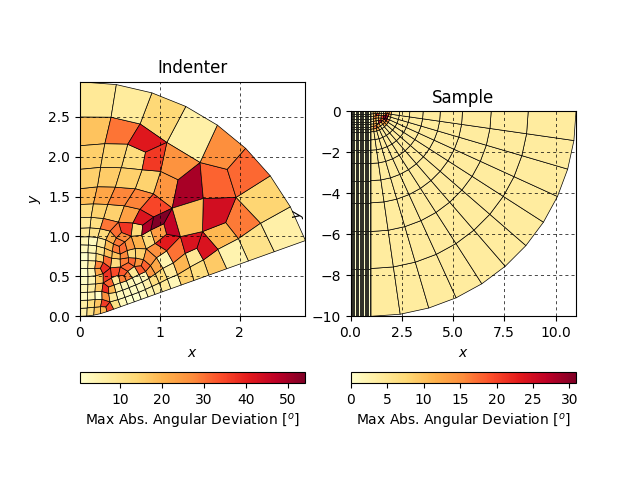

/home/lcharleux/Documents/Informatique/anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py:501: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [10]:
i = 1
fig = plt.figure()
parts_names = parts.keys()
for name, part in parts.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 2, i)
    ax.set_aspect("equal")
    ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.add_collection(patches)
    cbar = plt.colorbar(patches, orientation = "horizontal")
    cbar.set_label("Max Abs. Angular Deviation [$^o$]")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.grid()
    plt.title(name.title())
    i+= 1
plt.show()


## Simulation

## Post-Processing

### Time data


In [11]:
hist = model.data["history"]
hist.head()

,Wes,Wf,RF,Wtot,dtot,dtip,Wei,CF,Wps,t,step,F
0,0.000000e+00,0.0,-0.000000,0.000000e+00,0.000,0.000000,0.000000e+00,0.0,0.0,0.00,0,0.000000
1,1.551044e-08,0.0,-0.000025,2.913694e-08,-0.002,-0.001598,4.527072e-09,0.0,0.0,0.01,0,-0.000025
2,7.725865e-08,0.0,-0.000071,1.374515e-07,-0.004,-0.003053,2.598622e-08,0.0,0.0,0.02,0,-0.000071
3,2.503104e-07,0.0,-0.000170,3.783753e-07,-0.006,-0.004348,9.346720e-08,0.0,0.0,0.03,0,-0.000170
4,5.718712e-07,0.0,-0.000268,8.160462e-07,-0.008,-0.005641,2.087147e-07,0.0,0.0,0.04,0,-0.000268


<IPython.core.display.Javascript object>


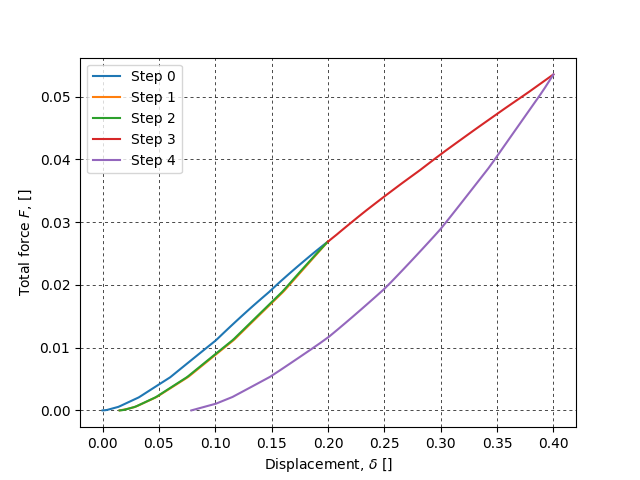

In [12]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(-group.dtot, -group.F, label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

### Fields

In [12]:
model.parts["sample"].mesh.fields_metadata()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,S,I_SAMPLE,node,LOADING1,0
1,0,0,U,I_SAMPLE,node,LOADING1,0
2,1,1,S,I_SAMPLE,node,LOADING1,0
3,1,1,U,I_SAMPLE,node,LOADING1,0
4,0,0,S,I_SAMPLE,node,UNLOADING1,1
5,0,0,U,I_SAMPLE,node,UNLOADING1,1
6,1,1,S,I_SAMPLE,node,UNLOADING1,1
7,1,1,U,I_SAMPLE,node,UNLOADING1,1
8,0,0,S,I_SAMPLE,node,RELOADING1,2
9,0,0,U,I_SAMPLE,node,RELOADING1,2


In [13]:
model.parts["sample"].mesh.fields_metadata()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,S,I_SAMPLE,node,LOADING1,0
1,0,0,U,I_SAMPLE,node,LOADING1,0
2,1,1,S,I_SAMPLE,node,LOADING1,0
3,1,1,U,I_SAMPLE,node,LOADING1,0
4,0,0,S,I_SAMPLE,node,UNLOADING1,1
5,0,0,U,I_SAMPLE,node,UNLOADING1,1
6,1,1,S,I_SAMPLE,node,UNLOADING1,1
7,1,1,U,I_SAMPLE,node,UNLOADING1,1
8,0,0,S,I_SAMPLE,node,RELOADING1,2
9,0,0,U,I_SAMPLE,node,RELOADING1,2


<IPython.core.display.Javascript object>


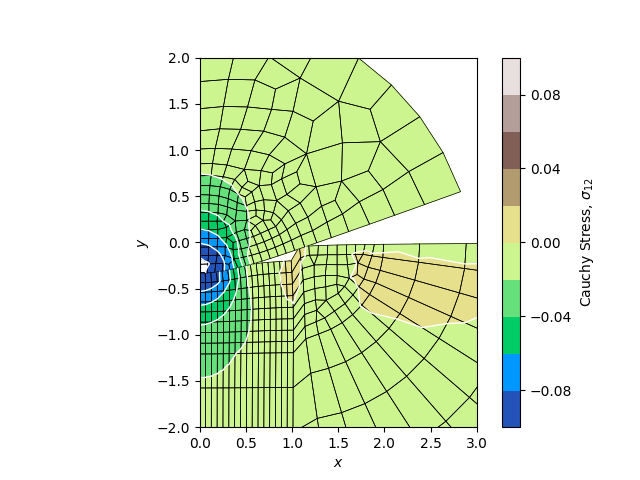

In [14]:
parts = {k:part.mesh.copy() for k, part in model.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
ax.set_xlim(0., 3.)
ax.set_ylim(-2., 2.)

field_num = 14 
disp_num = 15
levels = np.linspace(-1.e-1, 1.e-1, 11)

for k, mesh in parts.items():
    field = mesh.fields[field_num].data.v22
    disp = mesh.fields[disp_num].data
    mesh.nodes[("coords", "x")] += disp.v1
    mesh.nodes[("coords", "y")] += disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .5) 
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.terrain, alpha = 1)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 1.)
    ax.add_collection(patches)
cbar = plt.colorbar(grad)
cbar.set_label("Cauchy Stress, $\sigma_{12}$")
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.grid()